#### This notebook explores how different types of noise and outliers can affect clustering algorithms. We implement and compare various noise injection strategies — from simple uniform outliers to more statistically grounded and subtle multivariate perturbations. By visualizing and analyzing each method, we aim to understand how realistic or adversarial noise can challenge the reliability and robustness of unsupervised learning techniques.

#Setup Environment

In [1]:
import os
import sys
import copy
import torch
import itertools
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


In [3]:
def plot(df, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))

    # Fallbacks
    labels = np.array(labels) if labels is not None else np.ones(len(df))
    probabilities = np.array(probabilities) if probabilities is not None else np.ones(len(df))

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]  # Noise is black

        class_members = (labels == k)
        for i, row in df[class_members].iterrows():
            ax.plot(
                row.iloc[0],  # First column as x
                row.iloc[1],  # Second column as y
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * probabilities[i],
            )

    n_clusters_ = len(unique_labels) - (1 if -1 in unique_labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        title += " | " + ", ".join(f"{k}={v}" for k, v in parameters.items())

    ax.set_title(title)
    plt.tight_layout()

In [4]:
def plot_feature_pairs(df, figsize=(16, 12)):
    features = df['data'].columns.tolist()
    feature_pairs = list(itertools.combinations(features, 2))

    plt.figure(figsize=figsize)
    for i, (x_feat, y_feat) in enumerate(feature_pairs, 1):
        plt.subplot(2, 3, i)
        for label in df['target_names']:
            subset = df['frame'][df['frame']['target'] == df['target_names'].tolist().index(label)]
            plt.scatter(subset[x_feat], subset[y_feat], label=label, alpha=0.7)
        plt.xlabel(x_feat)
        plt.ylabel(y_feat)
        plt.title(f'{x_feat} vs {y_feat}')
        plt.legend()
    plt.tight_layout()
    plt.show()

##Load Iris Dataset

In [5]:
df_iris = datasets.load_iris(as_frame=True)

#Original data and its distribution visualization

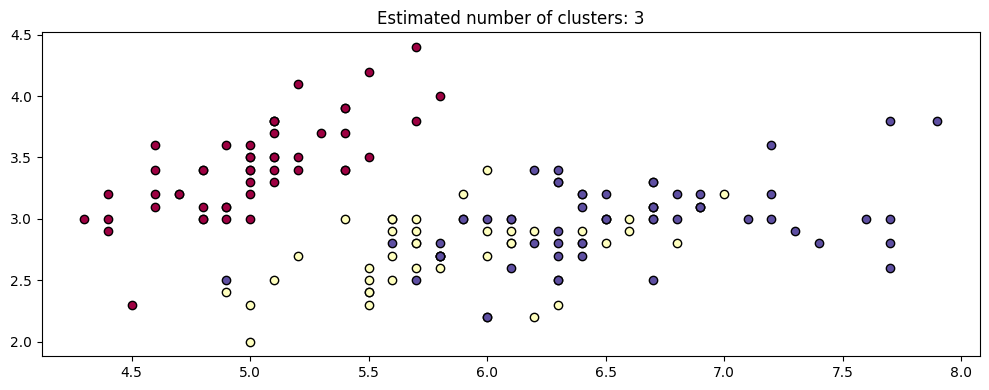

In [12]:
plot(df_iris['data'], labels=df_iris['target'])

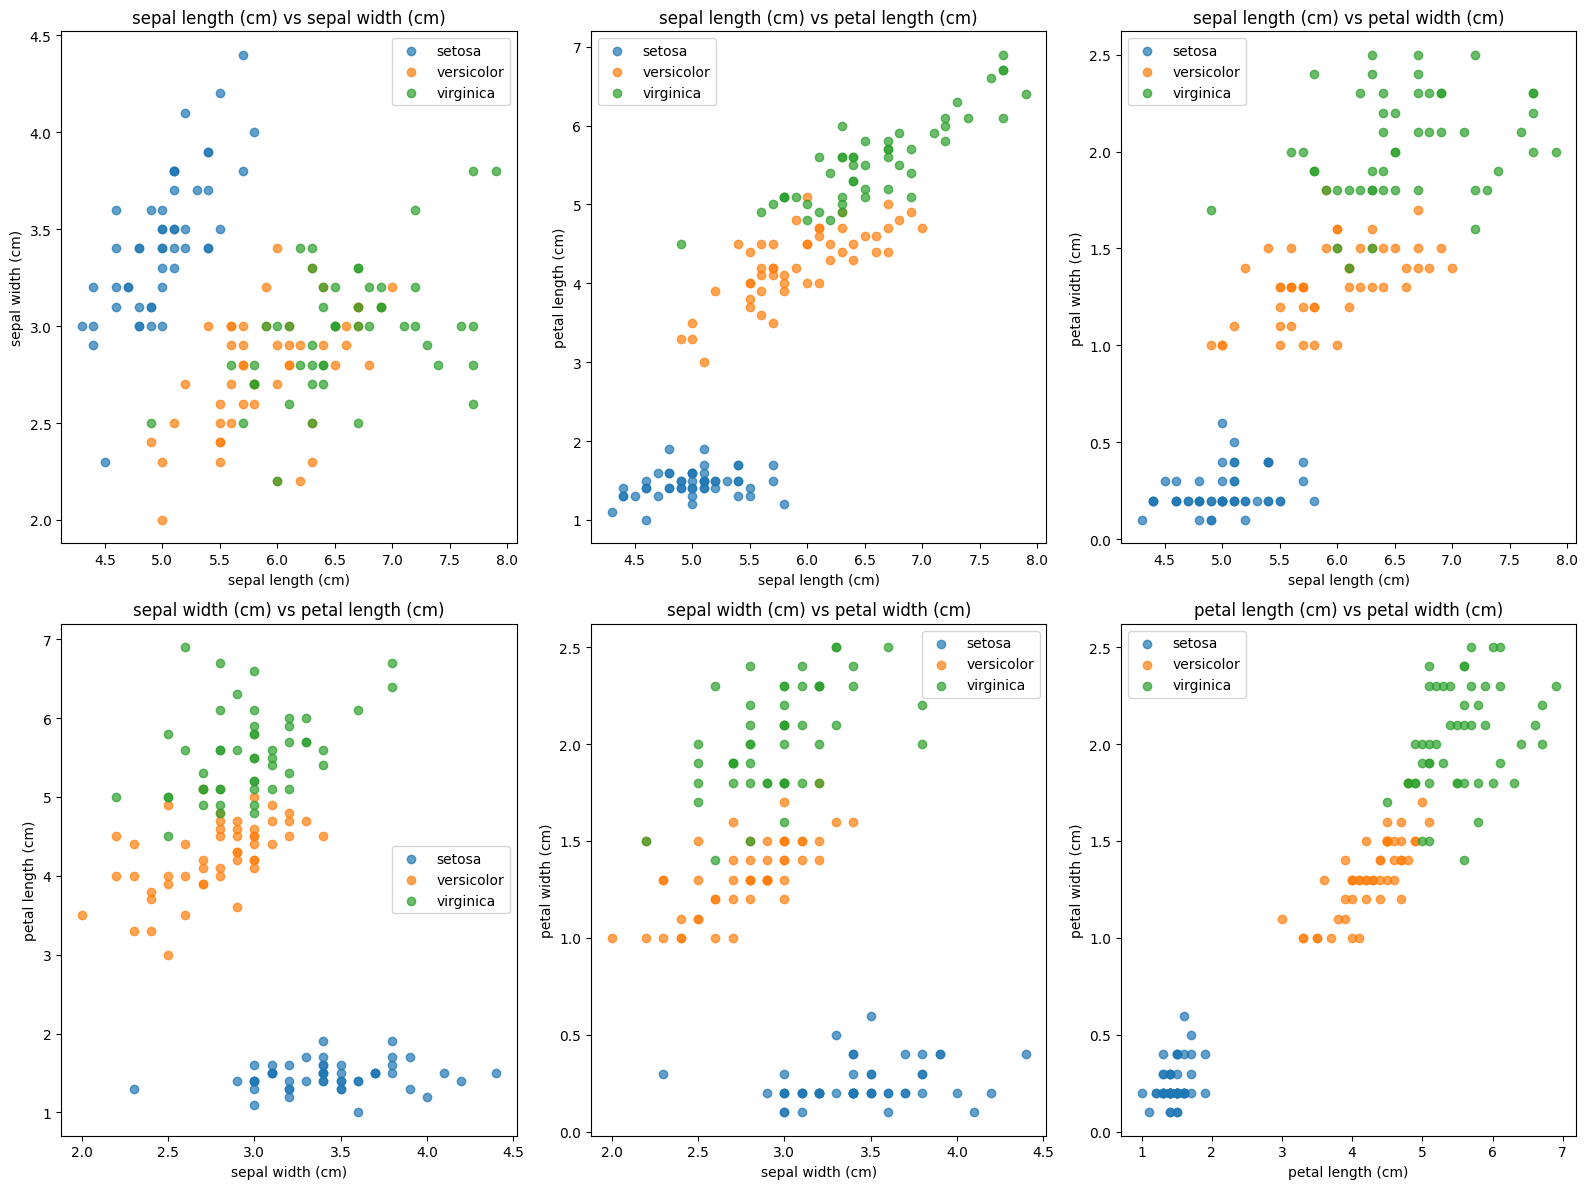

In [32]:
plot_feature_pairs(df_iris, figsize=(16, 12))

#Modified data and its distribution visualization

##Added some random Gaussian noise to the whole data, no more instances were added

Added some random Gaussian noise to the whole data, no more instances were added. This method makes the clusters more "fuzzy", making the boundary between two clusters less visible, disturbing the intra-cluster and inter-cluster distances.

In [7]:
df_noisy = copy.deepcopy(df_iris)
noise = np.random.normal(loc=0, scale=0.2, size=df_noisy['frame'].iloc[:, :4].shape)
df_noisy['data'].iloc[:, :4] += noise
df_noisy['frame'].iloc[:, :4] += noise

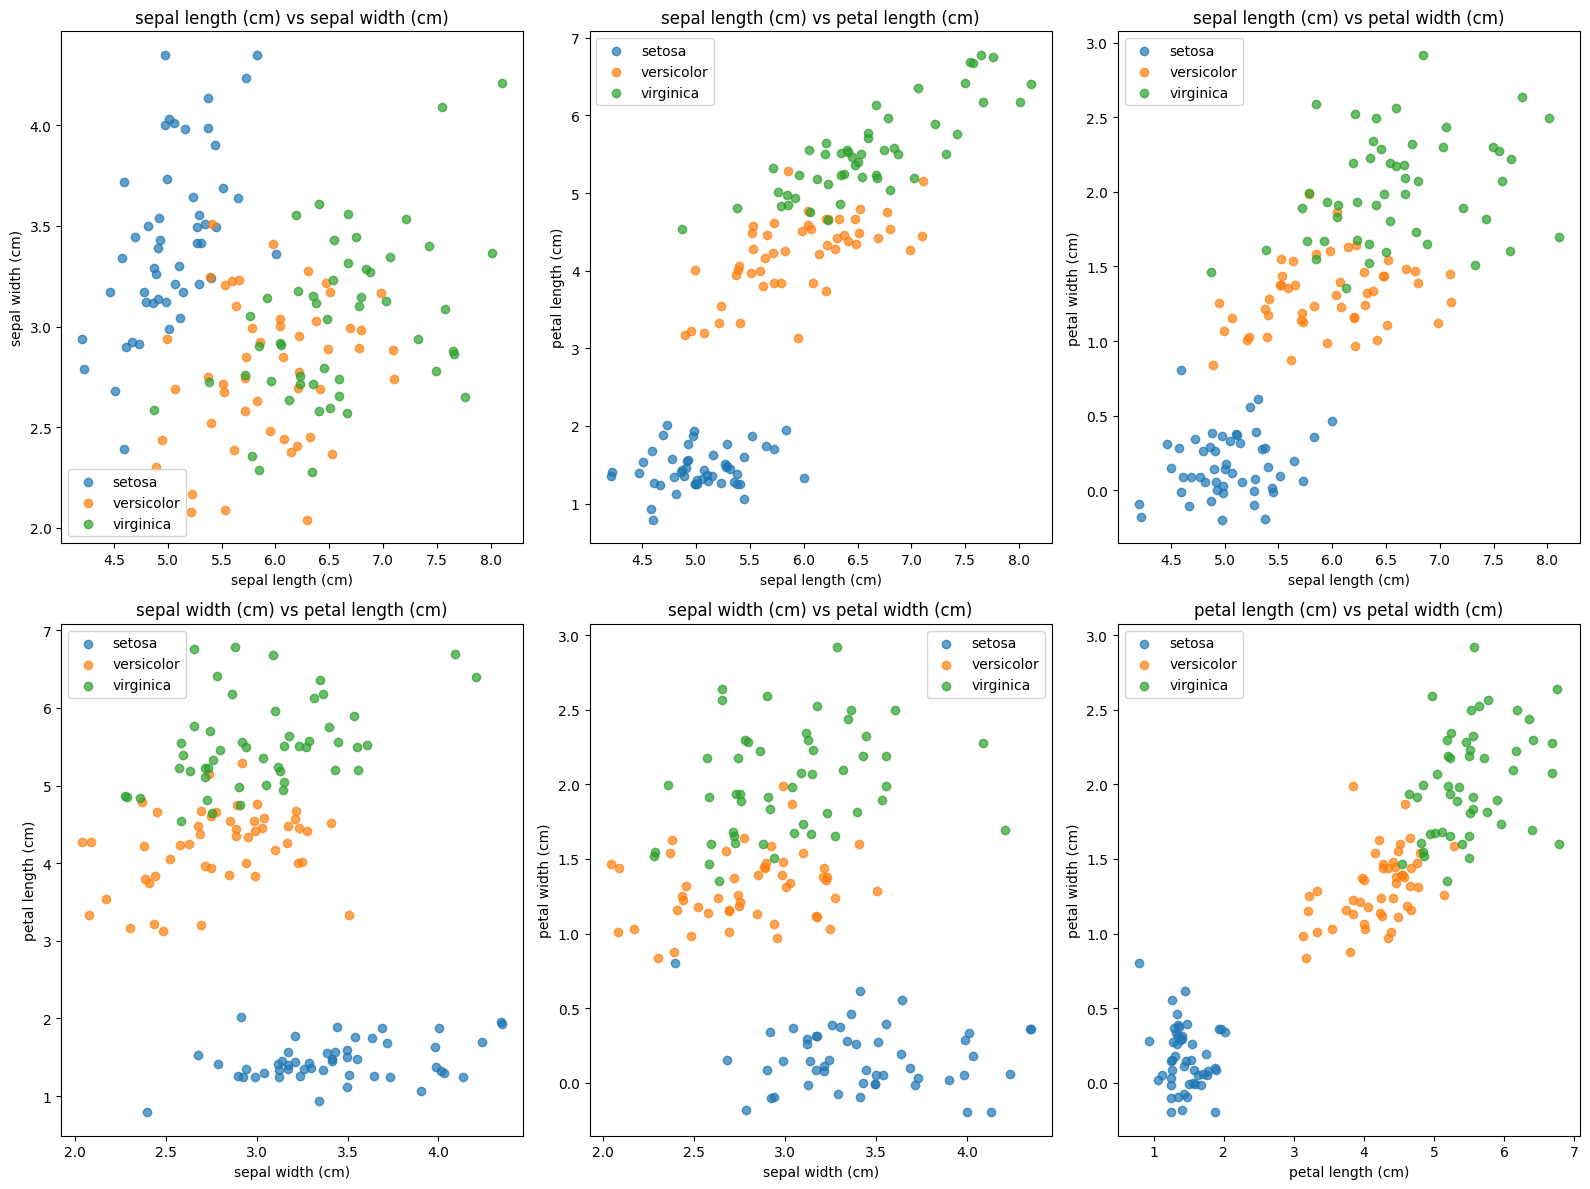

In [8]:
plot_feature_pairs(df_noisy, figsize=(16, 12))

##Added outliers based on inital guess for the data

Outliers are generated using fixed uniform ranges far outside the observed data. This method creates extreme values that are easy to detect, making them suitable for testing robust clustering algorithms. However, they may not reflect realistic noise patterns.

In [9]:
outliers = pd.DataFrame({
    'sepal length (cm)': np.random.uniform(10, 15, 5),
    'sepal width (cm)': np.random.uniform(5, 10, 5),
    'petal length (cm)': np.random.uniform(10, 15, 5),
    'petal width (cm)': np.random.uniform(5, 10, 5)
})
target = pd.DataFrame({'target': [3] * 5})
df_outlier = copy.deepcopy(df_iris)
df_outlier['data'] = pd.concat([df_iris['data'], outliers], ignore_index=True)
df_outlier['frame'] = pd.concat([df_iris['frame'], pd.concat([outliers, target], axis=1)], ignore_index=True)
df_outlier['target_names'] = np.append(df_outlier['target_names'], ['noise'])

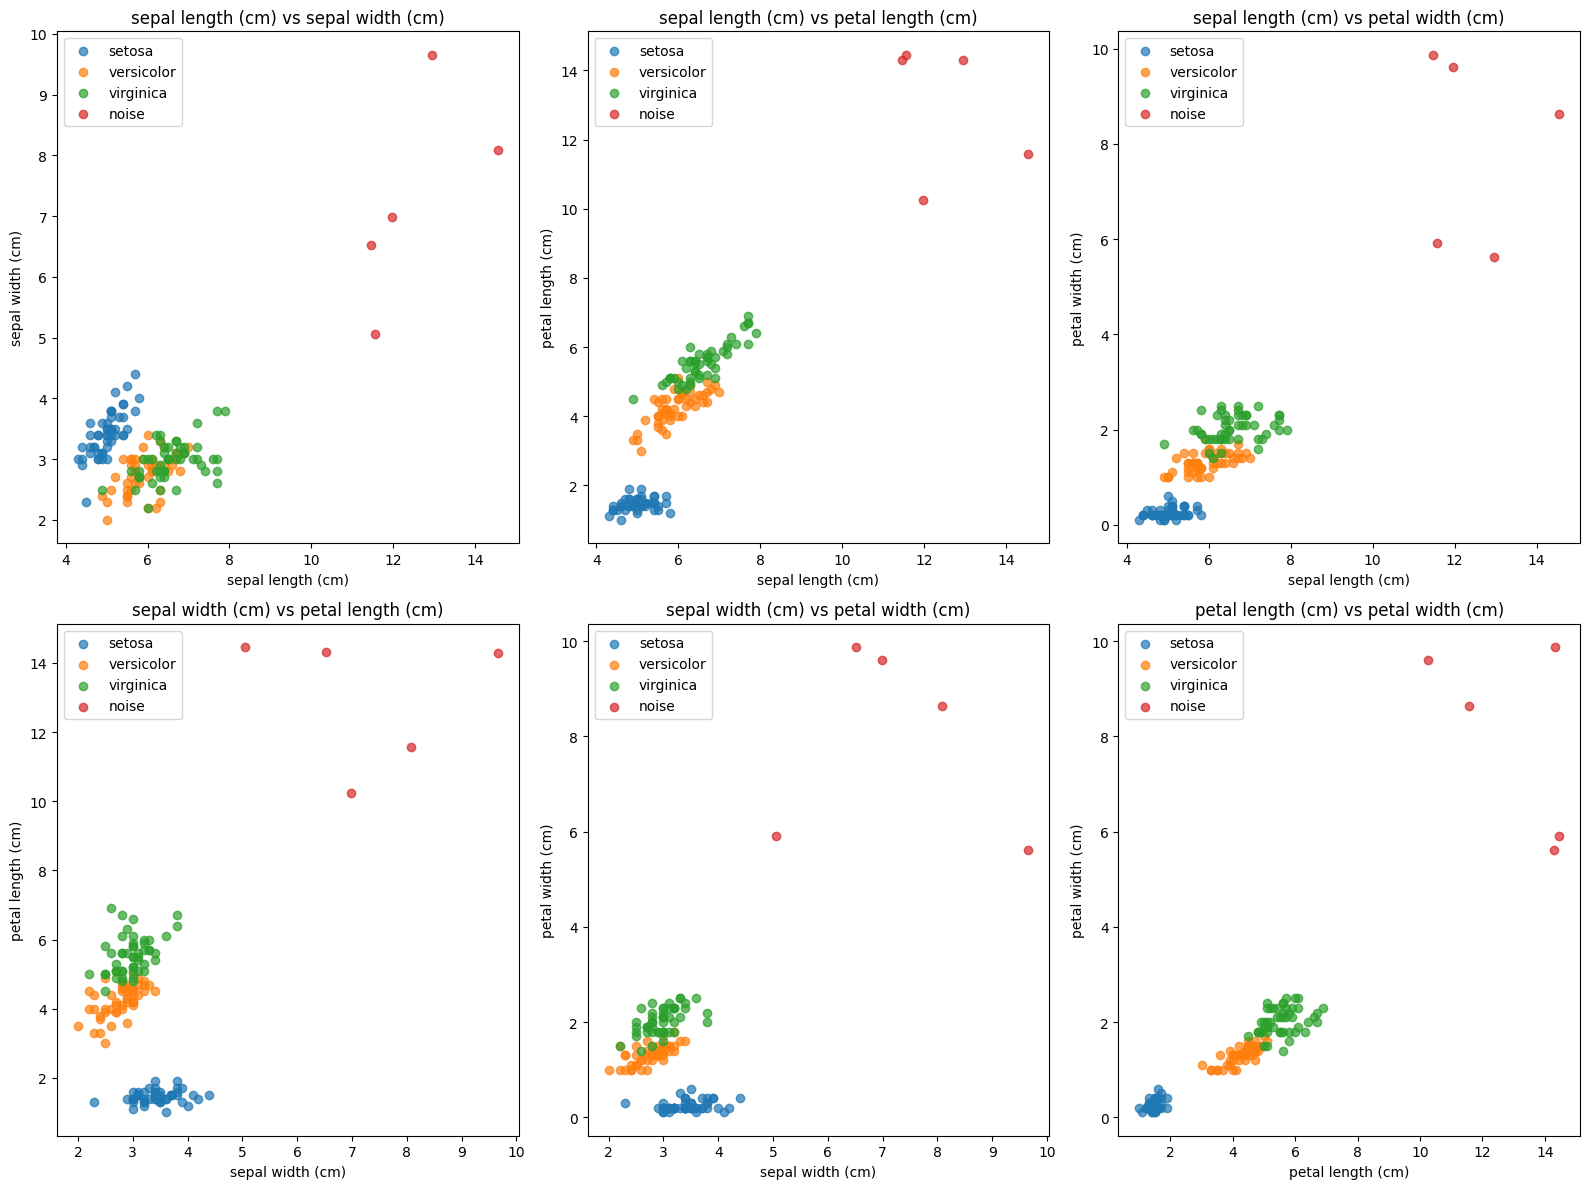

In [10]:
plot_feature_pairs(df_outlier, figsize=(16, 12))

##Added subtle outliers that blend into existing data points

In [ ]:
def generate_subtle_outliers(df, n_outliers=5, exaggeration_factor=1.5, random_state=42):
    np.random.seed(random_state)
    features = df['data'].columns
    df_features = df['data'][features]

    #mean and covariance
    mean_vec = df_features.mean().values
    cov_matrix = np.cov(df_features.T)

    #generate multivariate normal noise scaled from the mean
    outliers = np.random.multivariate_normal(
        mean=mean_vec,
        cov=cov_matrix,
        size=n_outliers
    )
    #scale away from the mean to make them more "unusual", but not extreme
    centered_outliers = outliers - mean_vec
    outliers_scaled = mean_vec + exaggeration_factor * centered_outliers

    outlier_df = copy.deepcopy(df)
    outlier_df['data'] = pd.concat([df['data'], pd.DataFrame(outliers_scaled, columns=features)], ignore_index=True)
    outlier_df['frame'] = pd.DataFrame(outliers_scaled, columns=features)
    outlier_df['frame']['target'] = outlier_df['target'].apply(lambda x: 3)
    outlier_df['target_names'] = np.append(outlier_df['target_names'], ['noise'])
    outlier_df['frame'] = pd.concat([df['frame'], outlier_df['frame']], ignore_index=True)

    return outlier_df

Outliers are generated using a multivariate normal distribution derived from the dataset's covariance structure and scaled slightly away from the mean. This method introduces realistic but misleading data points that respect the data's internal correlations. These outliers are hard to distinguish, making them excellent for testing clustering robustness under realistic noise.

Subtle outliers are harder to detect and can only be spotted on the plots due to the highlighting. Choosing the right amount can have a larger negative effect on the dataset. Carefully choosing there position e.g planting them on the border of two clusters can also blend previously separate clusters together if the algorithm prevents it.

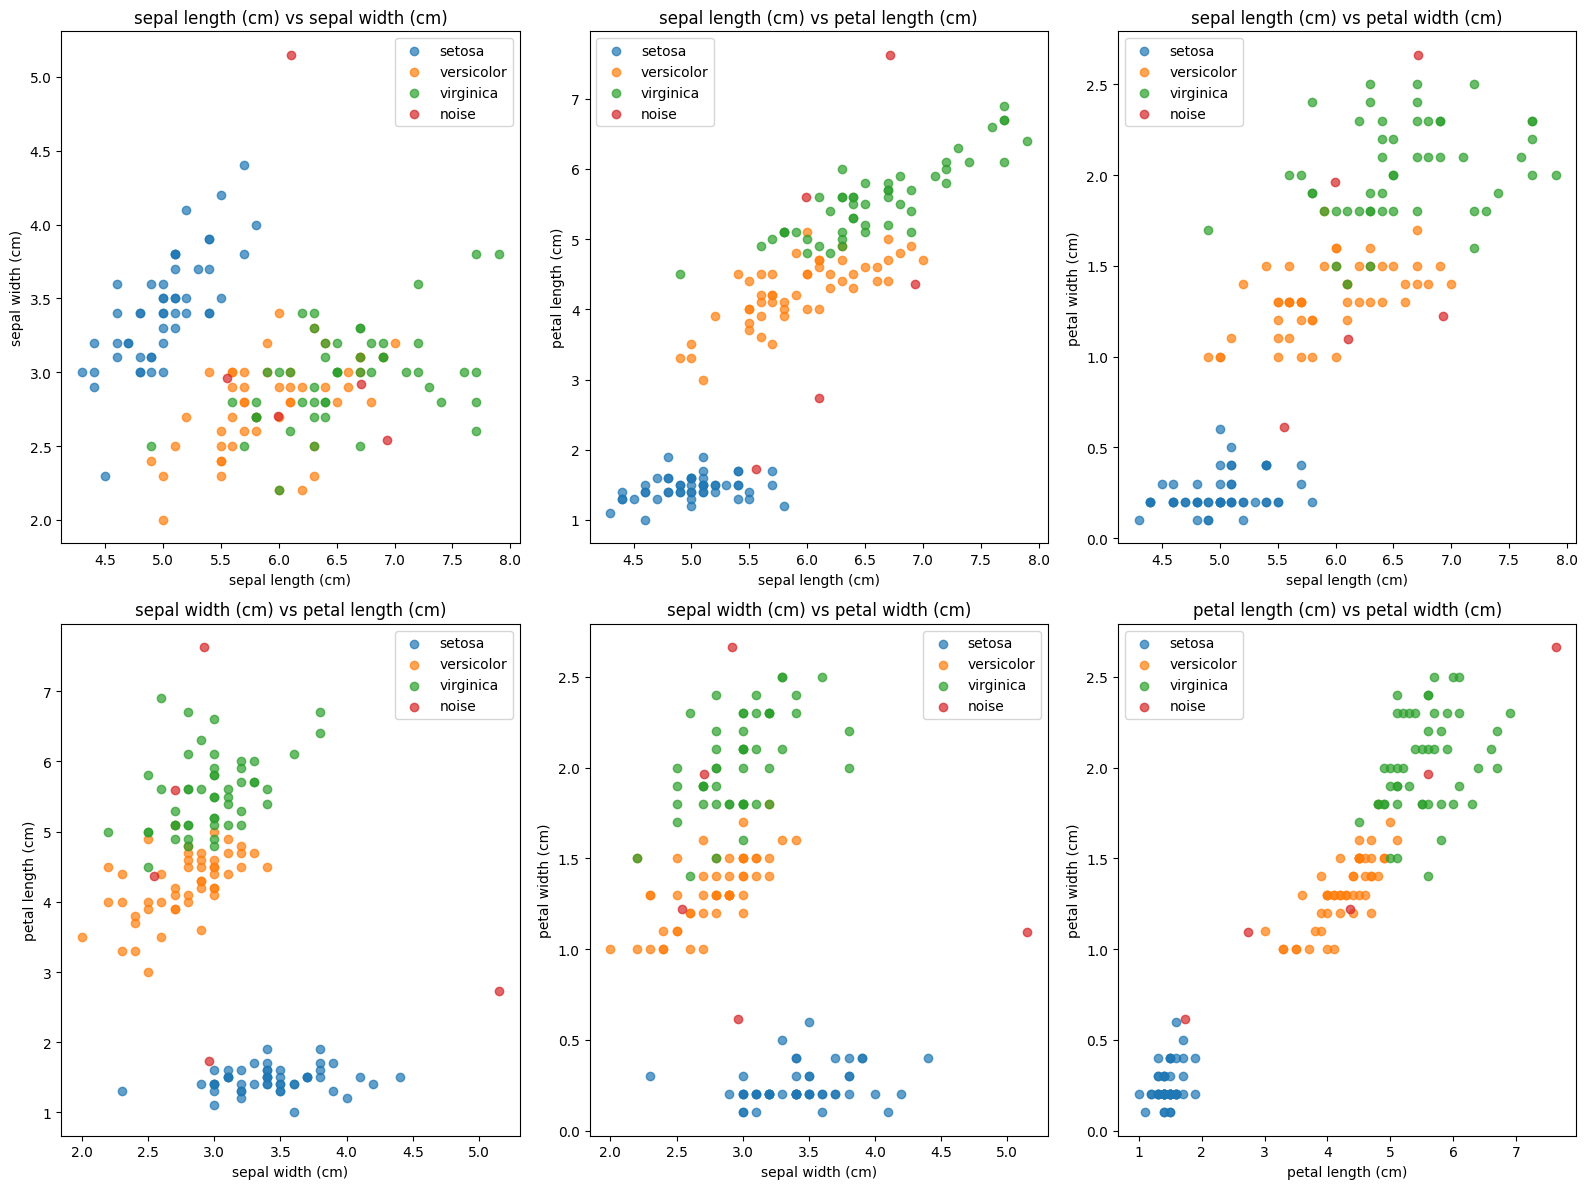

In [12]:
df_subtle_outliers = generate_subtle_outliers(df_iris, n_outliers=5, exaggeration_factor=2)
plot_feature_pairs(df_subtle_outliers, figsize=(16, 12))

##Shuffeled the data, 20% of the labels were shuffled

In this method, 20% of the dataset's class labels are randomly shuffled to introduce label noise. This simulates mislabeling errors or ambiguous instances that could misguide clustering evaluation or semi-supervised learning techniques. The underlying feature vectors remain unchanged, making this a subtle but impactful form of disturbance.

In [13]:
df_label_shuffled = copy.deepcopy(df_iris)

np.random.seed(42)
fraction_to_shuffle = 0.2
num_to_shuffle = int(fraction_to_shuffle * len(df_label_shuffled['frame']))

indices_to_shuffle = np.random.choice(df_label_shuffled['frame'].index, size=num_to_shuffle, replace=False)

shuffled_labels = np.random.permutation(df_label_shuffled['frame'].loc[indices_to_shuffle, 'target'].values)
df_label_shuffled['frame'].loc[indices_to_shuffle, 'target'] = shuffled_labels

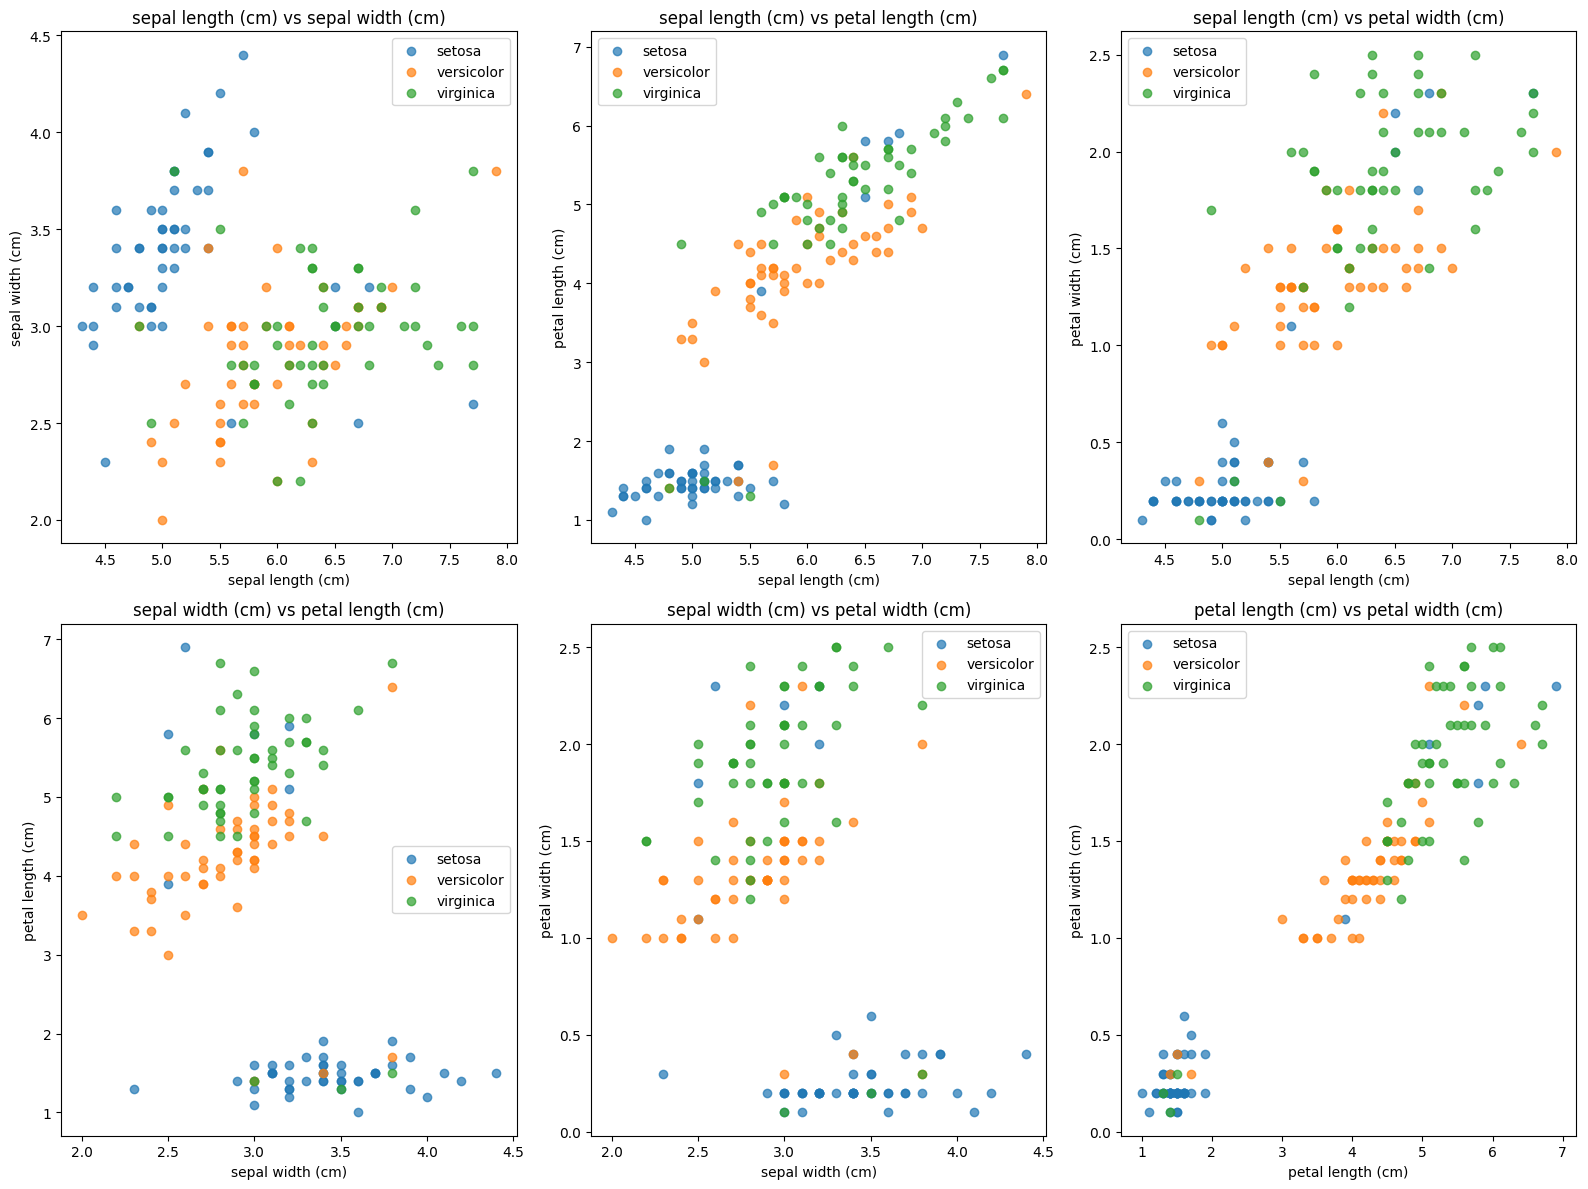

In [14]:
plot_feature_pairs(df_label_shuffled, figsize=(16, 12))

##Autoencoder with Outlier Generator

This method trains an autoencoder to learn the distribution of clean data and a generator network to produce realistic but slightly deviating samples—controlled outliers—based on a soft distance constraint from the data mean. During inference, the generator creates subtle anomalies that resemble real data but are intentionally distinct. These model-generated outliers can be used to test clustering robustness or enhance anomaly detection datasets.

This code standardizes the Iris dataset features using StandardScaler and converts them into a PyTorch tensor for model training. Standardization ensures that each feature has mean 0 and unit variance.

In [13]:
df = df_iris.data.copy()


scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)


Defines an autoencoder to learn the structure of input data and a generator to produce controlled outliers. The soft_outlier_loss encourages generated samples to stay within a target distance range from the real data mean.

In [ ]:
#Autoencoder
class AE(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

#Outlier Generator
class OutlierGenerator(nn.Module):
    def __init__(self, input_dim, noise_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, noise):
        return self.model(noise)
    

def soft_outlier_loss(fake, real_mean, target_min=1.5, target_max=3.5):
    distances = torch.norm(fake - real_mean, dim=1)
    loss_low = torch.relu(target_min - distances) ** 2
    loss_high = torch.relu(distances - target_max) ** 2
    return (loss_low + loss_high).mean() #Generate

Trains an autoencoder to reconstruct the normalized data and a generator to produce realistic but slightly outlying samples by optimizing a soft distance-based loss around the autoencoder’s reconstruction mean.

In [8]:
#instantiate models
input_dim = X_tensor.shape[1]
noise_dim = 16
ae_model = AE(input_dim)
outlier_generator = OutlierGenerator(input_dim, noise_dim)

ae_optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.001)
gen_optimizer = torch.optim.Adam(outlier_generator.parameters(), lr=0.001)
mse_loss = nn.MSELoss()

ae_model.train()
for epoch in range(500):
    ae_optimizer.zero_grad()
    recon, _ = ae_model(X_tensor)
    loss = mse_loss(recon, X_tensor)
    loss.backward()
    ae_optimizer.step()

with torch.no_grad():
    real_recon, _ = ae_model(X_tensor)
    real_mean = real_recon.mean(dim=0, keepdim=True)

outlier_generator.train()
for epoch in range(1000):
    gen_optimizer.zero_grad()
    noise = torch.randn(32, noise_dim)
    fake_samples = outlier_generator(noise)
    loss = soft_outlier_loss(fake_samples, real_mean)
    loss.backward()
    gen_optimizer.step()

Generates 10 synthetic outlier samples using the trained generator, appends them to the original data, and inversely scales the combined dataset back to the original feature space.

In [ ]:
# Generate outliers and append to the original data
outlier_generator.eval()
with torch.no_grad():
    num_outliers = 10
    noise = torch.randn(num_outliers, noise_dim)
    generated_outliers = outlier_generator(noise)

# Combine and inverse scale
X_combined = torch.cat([X_tensor, generated_outliers], dim=0).numpy()
df_final = pd.DataFrame(scaler.inverse_transform(X_combined), columns=df.columns)


Df correction to be suitable for plotting

In [ ]:

df_original = df_iris['frame'].copy()
noise_target_index = len(df_iris['target_names']) 
df_outliers = pd.DataFrame(
    scaler.inverse_transform(generated_outliers.numpy()),
    columns=df.columns
)
df_outliers['target'] = noise_target_index 
df_combined = pd.concat([df_original, df_outliers], ignore_index=True)
df_extended = {
    'data': df_combined[df_iris['data'].columns],
    'frame': df_combined,
    'target_names': np.array(list(df_iris['target_names']) + ['noise'])
}

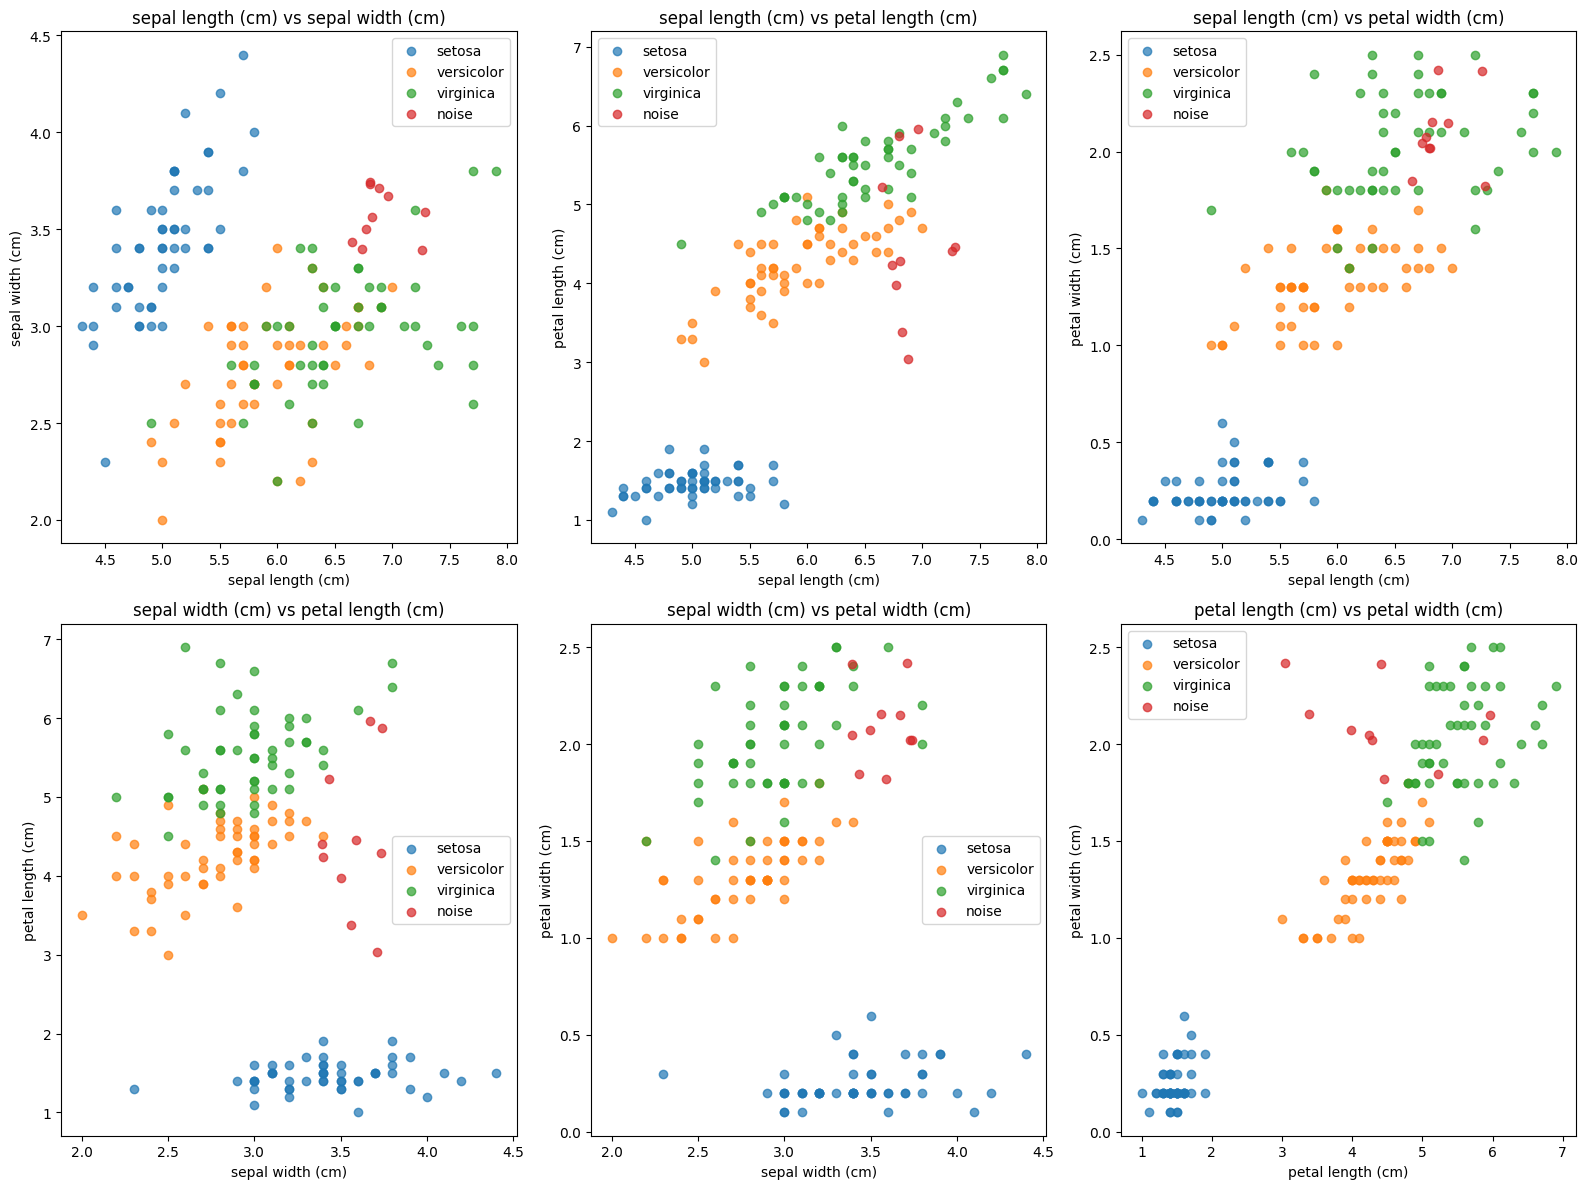

In [12]:
plot_feature_pairs(df_extended, figsize=(16, 12))

#Clustering

In [14]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)

##Initial Clustering Without Poisoning

In [16]:
y_kmeans_origin = kmeans.fit_predict(df_iris['data'])

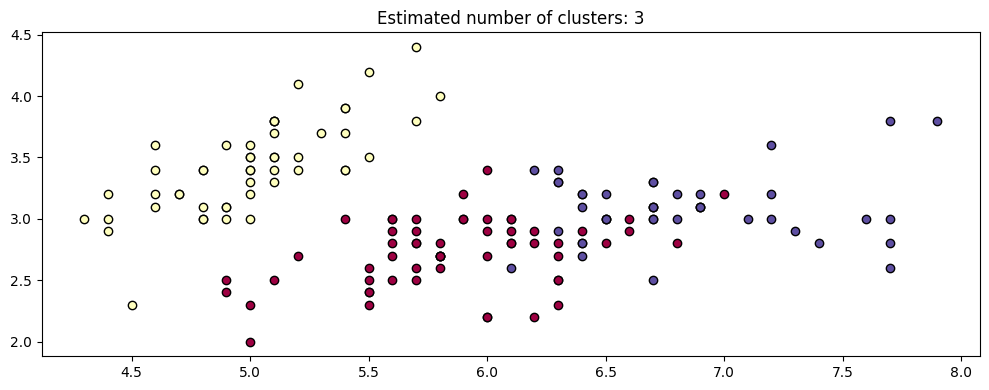

In [17]:
plot(df_iris['data'], y_kmeans_origin)

In [18]:
silhouette_avg_origin = silhouette_score(df_iris['data'], y_kmeans_origin)
print(f"Silhouette Score: {silhouette_avg_origin}")

calinski_harabasz_origin = calinski_harabasz_score(df_iris['data'], y_kmeans_origin)
print(f"Calinski-Harabasz Index: {calinski_harabasz_origin}")

davies_bouldin_origin = davies_bouldin_score(df_iris['data'], y_kmeans_origin)
print(f"Davies-Bouldin Index: {davies_bouldin_origin}")

Silhouette Score: 0.5528190123564102
Calinski-Harabasz Index: 561.62775662962
Davies-Bouldin Index: 0.6619715465007465


##Clustering on data with random noise

Random noise seems to skew the clustering quite a bit. The original clusters are still visible on the plot, but the metrics reveal a worse performance than the original.

In [19]:
y_kmeans_noisy = kmeans.fit_predict(df_noisy['data'])

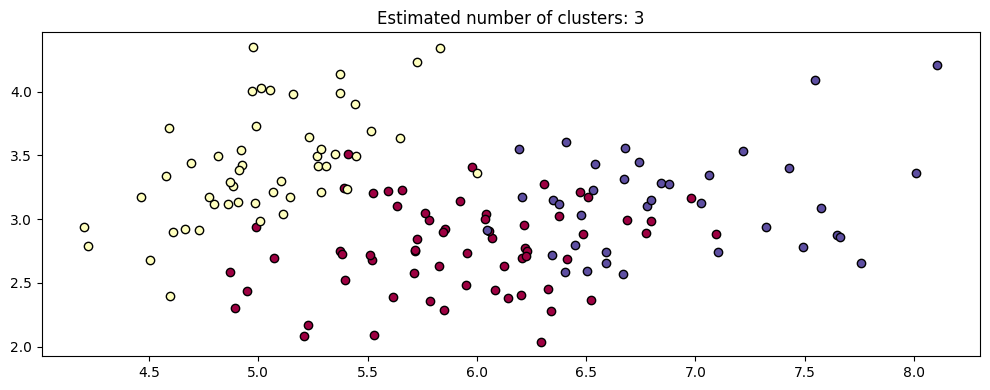

In [20]:
plot(df_noisy['data'], y_kmeans_noisy)

In [21]:
silhouette_avg_noisy = silhouette_score(df_noisy['data'], y_kmeans_noisy)
print(f"Silhouette Score: {silhouette_avg_noisy}")

calinski_harabasz_noisy = calinski_harabasz_score(df_noisy['data'], y_kmeans_noisy)
print(f"Calinski-Harabasz Index: {calinski_harabasz_noisy}")

davies_bouldin_noisy = davies_bouldin_score(df_noisy['data'], y_kmeans_noisy)
print(f"Davies-Bouldin Index: {davies_bouldin_noisy}")

Silhouette Score: 0.5164461762402804
Calinski-Harabasz Index: 444.0583813321562
Davies-Bouldin Index: 0.7340778038726107


##Clustering on data with outliers based on initial guess

Due to the new data points being distant and the nature of K-means (fixed number of clusters and no ability to detect noise) the results do not look like the original. The metrics however show a better score overall, due to the generated outliers being their own cluster and so distant that they appear well separated. Due to these reasons, they would be easy to detect with outlier and anomaly detection methods.

In [22]:
y_kmeans_outlier = kmeans.fit_predict(df_outlier['data'])

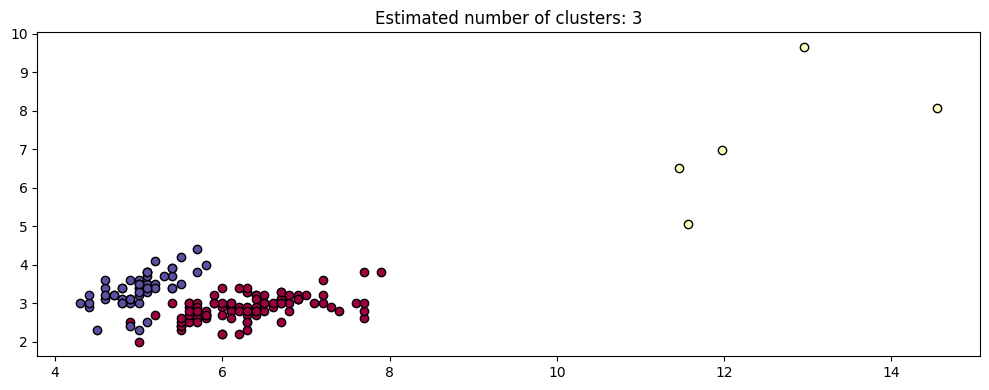

In [23]:
plot(df_outlier['data'], y_kmeans_outlier)

In [24]:
silhouette_avg_outlier = silhouette_score(df_outlier['data'], y_kmeans_outlier)
print(f"Silhouette Score: {silhouette_avg_outlier}")

calinski_harabasz_outlier = calinski_harabasz_score(df_outlier['data'], y_kmeans_outlier)
print(f"Calinski-Harabasz Index: {calinski_harabasz_outlier}")

davies_bouldin_outlier = davies_bouldin_score(df_outlier['data'], y_kmeans_outlier)
print(f"Davies-Bouldin Index: {davies_bouldin_outlier}")

Silhouette Score: 0.6790634634217514
Calinski-Harabasz Index: 547.6358382122479
Davies-Bouldin Index: 0.37859466653884394


##Clustering on data with subtle outliers

Subtle outliers as expected, blend into the data much more. Due to the small number of new data introduced, the metrics are not that much worse compared to the original.

In [25]:
y_kmeans_subtle = kmeans.fit_predict(df_subtle_outliers['data'])

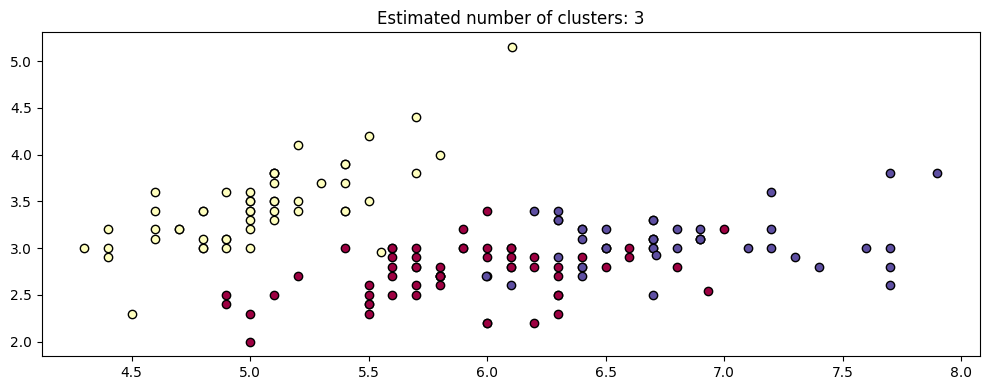

In [26]:
plot(df_subtle_outliers['data'], y_kmeans_subtle)

In [27]:
silhouette_avg_subtle = silhouette_score(df_subtle_outliers['data'], y_kmeans_subtle)
print(f"Silhouette Score: {silhouette_avg_subtle}")

calinski_harabasz_subtle = calinski_harabasz_score(df_subtle_outliers['data'], y_kmeans_subtle)
print(f"Calinski-Harabasz Index: {calinski_harabasz_subtle}")

davies_bouldin_subtle = davies_bouldin_score(df_subtle_outliers['data'], y_kmeans_subtle)
print(f"Davies-Bouldin Index: {davies_bouldin_subtle}")

Silhouette Score: 0.5408056262065762
Calinski-Harabasz Index: 515.9775140818493
Davies-Bouldin Index: 0.6799655805428602


##Clustering on data with shuffled labels

Shuffling the labels has no effect on the clustering itself because of its unsupervised nature. However, it could be an effective attack when the larger machine learning solution depends on the groun throuth in some other way (i.e semi-supervised learning).

In [28]:
y_kmeans_shuffled = kmeans.fit_predict(df_label_shuffled['data'])

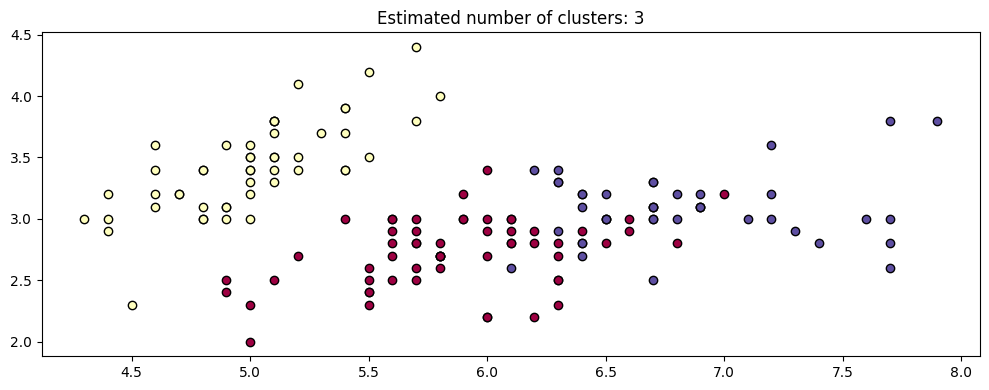

In [29]:
plot(df_label_shuffled['data'], y_kmeans_shuffled)

In [30]:
silhouette_avg_shuffled = silhouette_score(df_label_shuffled['data'], y_kmeans_shuffled)
print(f"Silhouette Score: {silhouette_avg_shuffled}")

calinski_harabasz_shuffled = calinski_harabasz_score(df_label_shuffled['data'], y_kmeans_shuffled)
print(f"Calinski-Harabasz Index: {calinski_harabasz_shuffled}")

davies_bouldin_shuffled = davies_bouldin_score(df_label_shuffled['data'], y_kmeans_shuffled)
print(f"Davies-Bouldin Index: {davies_bouldin_shuffled}")

Silhouette Score: 0.5528190123564102
Calinski-Harabasz Index: 561.62775662962
Davies-Bouldin Index: 0.6619715465007465


##Clustering on data with model generated noise

Model made outliers as intended by the training method, blend into the data much more. Even though the number of new instaces are 2x compared to the Subtle method, the metrics are better compared to that outlier injection method, making this a much more less noticable method.

In [15]:
y_kmeans_model = kmeans.fit_predict(df_extended['data'])

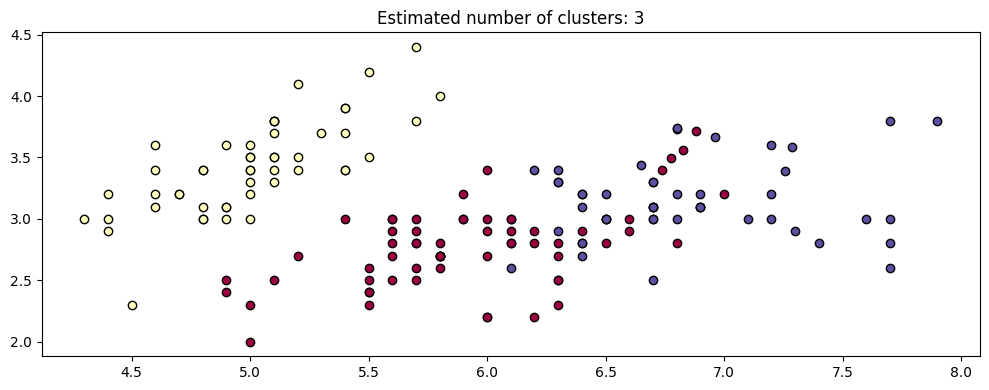

In [16]:
plot(df_extended['data'], y_kmeans_model)

In [19]:
silhouette_avg_model = silhouette_score(df_extended['data'], y_kmeans_model)
print(f"Silhouette Score: {silhouette_avg_model}")

calinski_harabasz_model = calinski_harabasz_score(df_extended['data'], y_kmeans_model)
print(f"Calinski-Harabasz Index: {calinski_harabasz_model}")

davies_bouldin_model = davies_bouldin_score(df_extended['data'], y_kmeans_model)
print(f"Davies-Bouldin Index: {davies_bouldin_model}")

Silhouette Score: 0.5211297305536133
Calinski-Harabasz Index: 502.9659199186784
Davies-Bouldin Index: 0.7209407236149529


#Evaluate Clustering

In [ ]:
metrics = pd.DataFrame({
    "Original": [silhouette_avg_origin, calinski_harabasz_origin, davies_bouldin_origin],
    "Noisy": [silhouette_avg_noisy, calinski_harabasz_noisy, davies_bouldin_noisy],
    "Outlier": [silhouette_avg_outlier, calinski_harabasz_outlier, davies_bouldin_outlier],
    "Subtle": [silhouette_avg_subtle, calinski_harabasz_subtle, davies_bouldin_subtle],
    "Shuffled": [silhouette_avg_shuffled, calinski_harabasz_shuffled, davies_bouldin_shuffled],
    "Model": [silhouette_avg_model, calinski_harabasz_model, davies_bouldin_model]
}, index=[
    'Silhouette Score',
    'Calinski-Harabasz Index',
    'Davies-Bouldin Index'
])

metrics

,Original,Noisy,Outlier,Subtle,Shuffled,Model
Silhouette Score,0.552819,0.516446,0.679063,0.540806,0.552819,0.521130
Calinski-Harabasz Index,561.627757,444.058381,547.635838,515.977514,561.627757,502.965920
Davies-Bouldin Index,0.661972,0.734078,0.378595,0.679966,0.661972,0.720941


##Conclusion
Internal clustering metrics can be misleading in adversarial settings. While they may show artificially inflated values when noise is extreme and separable, subtle attacks degrade cluster quality more stealthily. Therefore, visual inspection, domain knowledge, and robust clustering techniques are essential when working in potentially poisoned environments.